<h1>Importing libralies</h1>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

<h1>Loading dataset</h1>

In [23]:
df = pd.read_csv('../25RP21044_LOAN/dataset/train.csv')
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


<h1>Data inspection</h1>

In [24]:
df.head()
df.info()
df['loan_paid_back'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

<h1>Drop ID & Separate X / y</h1>

In [25]:
# Drop ID column
df = df.drop(columns=['id'])

# Separate features and target
X = df.drop(columns=['loan_paid_back'])
y = df['loan_paid_back']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (593994, 11)
Target shape: (593994,)


<h1>Identify categorical & Numerical features</h1>

In [26]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

print("Numerical features:")
print(num_features)

print("\nCategorical features:")
print(cat_features)


Numerical features:
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

Categorical features:
Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')


<h1>Building Preprocessing pipeline</h1>

In [27]:
# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

print("Preprocessing pipeline created successfully")

Preprocessing pipeline created successfully


<h1>Train and test split</h1>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))


Training set shape: (475195, 11)
Test set shape: (118799, 11)

Training target distribution:
loan_paid_back
1.0    0.798819
0.0    0.201181
Name: proportion, dtype: float64

Test target distribution:
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


<h1>DEFINE MODELS</h1>

In [29]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        n_jobs=-1
    )
}

print("Models defined successfully:")
for name in models:
    print("-", name)


Models defined successfully:
- Logistic Regression
- XGBoost
- LightGBM


<h1>Define Hyperparameter Grids for All Models</h1>

In [30]:
param_grids = {
    "Logistic Regression": {
        "model__C": [0.1, 1, 10]
    },
    "XGBoost": {
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
        "model__max_depth": [3, 5]
    },
    "LightGBM": {
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
        "model__num_leaves": [31, 50]
    }
}

print("Hyperparameter grids updated.")

Hyperparameter grids updated.


<h1>GridSearchCV + 5-Fold Cross-Validation</h1>

In [31]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train,
    y_train,
    test_size=0.8, 
    random_state=42,
    stratify=y_train
)

print("Original training shape:", X_train.shape)
print("Sampled training shape:", X_train_sample.shape)

print("\nSampled target distribution:")
print(y_train_sample.value_counts(normalize=True))

Original training shape: (475195, 11)
Sampled training shape: (95039, 11)

Sampled target distribution:
loan_paid_back
1.0    0.798819
0.0    0.201181
Name: proportion, dtype: float64


<h1>FAST GridSearchCV (5-Fold CV)</h1>

In [32]:
best_models = {}
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\n🔹 Training {model_name} ...")
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=kf,
        scoring="accuracy",
        n_jobs=-1
    )
    
    grid.fit(X_train_sample, y_train_sample)
    
    best_models[model_name] = grid.best_estimator_
    cv_results[model_name] = grid.best_score_
    
    print(f"Best CV Accuracy: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")



🔹 Training Logistic Regression ...
Best CV Accuracy: 0.9014
Best Params: {'model__C': 0.1}

🔹 Training XGBoost ...
Best CV Accuracy: 0.9033
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}

🔹 Training LightGBM ...
[LightGBM] [Info] Number of positive: 75919, number of negative: 19120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 95039, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Best CV Accuracy: 0.9041
Best Params: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 31}


In [33]:
# Select the best model 
best_model_name = "LightGBM"
best_model = best_models[best_model_name]

print("Selected Best Model:", best_model_name)


Selected Best Model: LightGBM


<h1>Best Model on FULL Training Data</h1>

In [34]:
# Retrain best model on full training data
best_model.fit(X_train, y_train)

print("Best LightGBM model retrained on full training data.")

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Best LightGBM model retrained on full training data.


<h1>Evalulate on the test data</h1>

In [35]:
y_test_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.9042163654576217

Classification Report:

              precision    recall  f1-score   support

         0.0       0.89      0.60      0.71     23900
         1.0       0.91      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799



<Figure size 600x600 with 0 Axes>

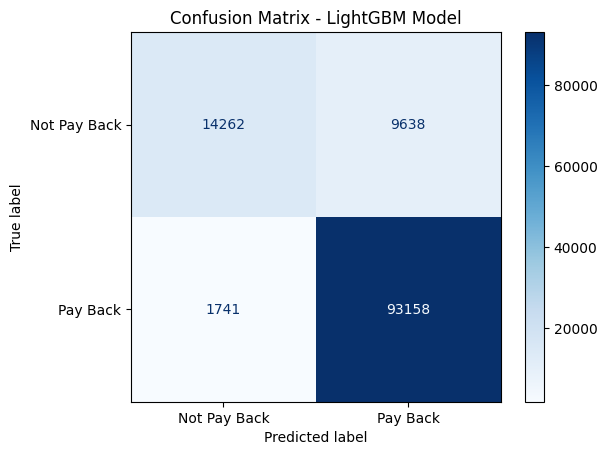

In [36]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Pay Back", "Pay Back"]
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LightGBM Model")
plt.show()


<h1>Save Model, Scaler, and Feature Columns</h1>

In [37]:
import joblib

# Save full pipeline model
joblib.dump(best_model, "best_lightgbm_model.pkl")

# Extract and save feature names after preprocessing
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
joblib.dump(feature_names, "feature_columns.pkl")

# Save the preprocessing pipeline (scaler + encoder)
joblib.dump(best_model.named_steps["preprocessor"], "scaler.pkl")

print("Model, scaler, and feature columns saved successfully.")


Model, scaler, and feature columns saved successfully.


<h1>Baseline Predictions</h1>

In [38]:
# Select baseline samples (unseen data)
baseline_X = X_test.sample(n=10, random_state=42)
baseline_y_true = y_test.loc[baseline_X.index]

print("Baseline input shape:", baseline_X.shape)
print("\nTrue labels:")
print(baseline_y_true.values)

Baseline input shape: (10, 11)

True labels:
[1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


<h2>Generate Baseline Predictions</h2>

In [39]:
# Predict class labels
baseline_y_pred = best_model.predict(baseline_X)

# Predict probabilities
baseline_y_prob = best_model.predict_proba(baseline_X)[:, 1]

# Combine results
baseline_results = baseline_X.copy()
baseline_results["Actual"] = baseline_y_true.values
baseline_results["Predicted"] = baseline_y_pred
baseline_results["Probability_Paid_Back"] = baseline_y_prob

baseline_results

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,Actual,Predicted,Probability_Paid_Back
444543,53735.45,0.172,695,23254.21,10.70,Male,Single,Bachelor's,Employed,Debt consolidation,C3,1.0,1.0,0.866060
283740,38883.01,0.079,721,7095.54,14.49,Female,Married,Bachelor's,Employed,Home,C4,1.0,1.0,0.982227
83522,61396.12,0.082,730,26296.61,12.11,Male,Married,Bachelor's,Unemployed,Business,C4,0.0,0.0,0.278474
347437,45964.21,0.098,653,23706.04,12.05,Female,Single,Bachelor's,Employed,Debt consolidation,D5,1.0,1.0,0.883695
241543,41045.25,0.068,641,18889.71,9.99,Male,Single,Bachelor's,Employed,Medical,D4,1.0,1.0,0.905465
261038,47746.38,0.103,674,17888.95,11.20,Male,Married,High School,Retired,Medical,C4,1.0,1.0,0.996786
445532,67250.05,0.110,566,18895.02,15.30,Female,Married,Bachelor's,Employed,Debt consolidation,F3,1.0,1.0,0.759764
291026,33006.61,0.208,692,751.44,12.28,Male,Divorced,Master's,Employed,Home,C2,1.0,1.0,0.782831
306491,49550.24,0.123,675,7758.34,12.05,Female,Married,Bachelor's,Self-employed,Other,C3,1.0,1.0,0.952968
301,30406.68,0.158,699,12557.03,9.94,Male,Single,High School,Employed,Debt consolidation,C4,1.0,1.0,0.940130


<h2>Save Baseline Predictions</h2>

In [40]:
baseline_results.to_csv("baseline_predictions.csv", index=False)
print("Baseline predictions saved successfully.")

Baseline predictions saved successfully.


<h2>Overfitting / Underfitting Check</h2>

In [41]:
# Training performance
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Test performance
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

Training Accuracy: 0.9055
Test Accuracy:     0.9042


<h1>Saving the pipeline</h1>

In [42]:
# Features / target
target = "loan_paid_back"
features = df.drop(columns=[target])
X = df[features.columns]
y = df[target]

#split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ensure X_train / X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

# Identify feature types

num_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
cat_features = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Build pipeline with LightGBM

best_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

#fit the pipeline
pipeline.fit(X_train, y_train)

#save
joblib.dump(pipeline, "full_pipeline_model.pkl")
print("Pipeline trained and saved successfully!")


[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Pipeline trained and saved successfully!
